In [63]:
from urllib.parse import urlparse
from urllib.parse import parse_qs
import requests
import json
import copy
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

In [43]:



url = 'https://www.flipkart.com/samsung-galaxy-f13-nightsky-green-64-gb/p/itmeadfda1bd23fa?pid=MOBGENJWF4KJTPEN&lid=LSTMOBGENJWF4KJTPENAUQVSZ&marketplace=FLIPKART&q=smart+phone&store=tyy%2F4io&srno=s_1_1&otracker=search&otracker1=search&fm=search-autosuggest&iid=a62ba7f4-2c5a-4968-9fc5-9b8bb4ba7f30.MOBGENJWF4KJTPEN.SEARCH&ppt=sp&ppn=sp&ssid=o659iis1ndttx6gw1661441303412&qH=a94e14abfa87c43a'
parsed_url = urlparse(url)
q_params= parse_qs(parsed_url.query)
captured_value = parse_qs(parsed_url.query)['marketplace'][0]
page_uri=""
page_uri = parsed_url.path.replace("/p/","/product-reviews/")

page_uri += "?"
page_uri += "pid="+q_params["pid"][0]+"&"
page_uri += "lid="+q_params["lid"][0]+"&"
page_uri += "aid=overall&certifiedBuyer=false&sortOrder=MOST_RECENT"
#page_uri += "&page=1"
print(captured_value)
print(parsed_url.path)
print(q_params["pid"])
print(q_params["lid"])

request_params={}
request_params["pageUri"]=page_uri
request_params["pageContext"]={}
request_params["pageContext"]["fetchSeoData"]="true" #True

print(request_params)
print("----------------------")
base_url ="https://1.rome.api.flipkart.com/api/4/page/fetch"
headers = {"Host": "1.rome.api.flipkart.com",
"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:103.0) Gecko/20100101 Firefox/103.0",
"Accept":"*/*",
"Accept-Language": "en-US,en;q=0.5",
"Accept-Encoding": "gzip, deflate, br",
"Content-Type": "application/json",
"Content-Length": "239",
"Origin": "https://www.flipkart.com",
"Sec-Fetch-Dest": "empty",
"Sec-Fetch-": "no-cors",
"Sec-Fetch-Site": "same-site",
"X-User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:103.0) Gecko/20100101 Firefox/103.0 FKUA/website/42/website/Desktop",
"Referer": "https://www.flipkart.com/",
"Connection": "keep-alive",
"Pragma": "no-cache",
"Cache-Control": "no-cache"}
r = requests.post(base_url, data= json.dumps(request_params),headers=headers)
print(r.status_code )

print(r.text)

print(type(r.text))


FLIPKART
/samsung-galaxy-f13-nightsky-green-64-gb/p/itmeadfda1bd23fa
['MOBGENJWF4KJTPEN']
['LSTMOBGENJWF4KJTPENAUQVSZ']
{'pageUri': '/samsung-galaxy-f13-nightsky-green-64-gb/product-reviews/itmeadfda1bd23fa?pid=MOBGENJWF4KJTPEN&lid=LSTMOBGENJWF4KJTPENAUQVSZ&aid=overall&certifiedBuyer=false&sortOrder=MOST_RECENT', 'pageContext': {'fetchSeoData': 'true'}}
----------------------
200
{"CACHE_INVALIDATION_TTL":"0","META_INFO":{"abContext":{"abWrapper":[]},"appConfigHash":null,"clientConfigHashMap":null,"dcInfo":null,"omnitureInfo":null},"REQUEST":null,"REQUEST-ID":"ab8031c8-e12c-4d4c-94b0-b93c6a5ab213","RESPONSE":{"pageData":{"backTTL":30000,"elementId":"page","hardTTL":2147483647,"hasMorePages":true,"infinitePage":false,"layoutParams":{"backgroundColor":"#F1F2F4","orientation":"","theme":"light"},"pageContext":{"type":"AllReviewsContext","bu":"AllReviewsContext","aspectId":"overall","aspectName":null,"certifiedBuyer":false,"fdpEventTracking":null,"fetchId":"ab8031c8-e12c-4d4c-94b0-b93c6a5a

Total reviews---> 7
*****page_count S*****
{'currentpage': 1, 'totalPages': 1}
*****page_count E*****
-----------------------


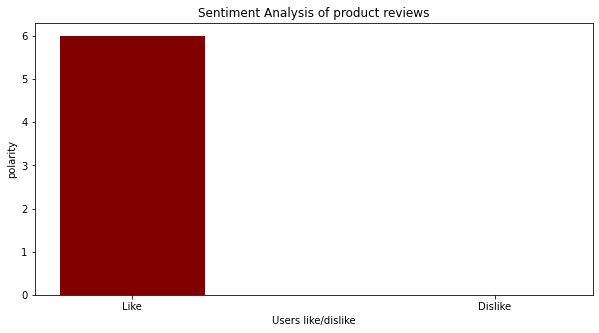

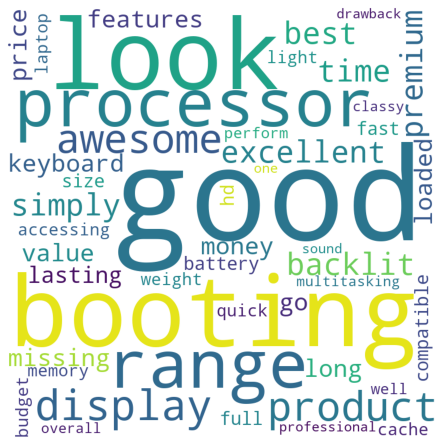

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [69]:
def extract_reviews(product_url):
    request_params = generate_request_params(product_url)
    reviews = process_reviews(request_params)
    return reviews
    
    
def generate_request_params(url):
    parsed_url = urlparse(url)
    q_params= parse_qs(parsed_url.query) 
    page_uri=""
    page_uri = parsed_url.path.replace("/p/","/product-reviews/")

    page_uri += "?"
    page_uri += "pid="+q_params["pid"][0]+"&"
    page_uri += "lid="+q_params["lid"][0]+"&"
    #page_uri += "aid=overall&certifiedBuyer=false&sortOrder=MOST_RECENT"
    page_uri += "aid=overall&certifiedBuyer=false"
    request_params={}
    request_params["pageUri"]=page_uri
    request_params["pageContext"]={}
    request_params["pageContext"]["fetchSeoData"]="true" 
    return request_params

def process_reviews(request_params):
    response = api_response(request_params)
    reviews = extract_data(response,"review")
    page_count_info = extract_data(response,"page_count")
    print("*****page_count S*****")
    print(page_count_info)
    print("*****page_count E*****")
    for c in range(1,page_count_info["totalPages"]):
        request_params_copy = copy.deepcopy(request_params)
        request_params_copy =   request_params_copy["pageUri"]+"&page="+str(c+1)
        response = api_response(request_params_copy)
        reviews_per_page = extract_data(response,"review")
        reviews = reviews+ reviews_per_page

    return reviews

def extract_data(response,extraction_type):
    return_val=[]
    if (extraction_type =="review"):
        if "RESPONSE" in response:
            slots= response["RESPONSE"]["slots"]
            for x in slots:
                if(x["slotType"]=="WIDGET" and x["widget"]["type"]=="REVIEWS"):
                    review=  x["widget"]["data"]["renderableComponents"][0]["value"]["text"]
                    return_val.append(review)
    if (extraction_type =="page_count"):
        return_val={}
        if "RESPONSE" in response:
            slots= response["RESPONSE"]["slots"]
            for x in slots:
                if(x["slotType"]=="WIDGET" and x["widget"]["type"]=="PAGINATION_BAR"):
                    currentpage=  x["widget"]["data"]["currentPage"] 
                    totalPages=  x["widget"]["data"]["totalPages"] 
                    return_val["currentpage"]= currentpage
                    return_val["totalPages"]= totalPages
                    
    if (extraction_type =="review"):
        print("Total reviews--->",len(return_val))
    return return_val

def api_response(request_params):
    #print ("API PARAMS-->",request_params)
    base_url ="https://1.rome.api.flipkart.com/api/4/page/fetch"
    headers = {"Host": "1.rome.api.flipkart.com",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:103.0) Gecko/20100101 Firefox/103.0",
    "Accept":"*/*",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br",
    "Content-Type": "application/json",
    "Content-Length": "239",
    "Origin": "https://www.flipkart.com",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-": "no-cors",
    "Sec-Fetch-Site": "same-site",
    "X-User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:103.0) Gecko/20100101 Firefox/103.0 FKUA/website/42/website/Desktop",
    "Referer": "https://www.flipkart.com/",
    "Connection": "keep-alive",
    "Pragma": "no-cache",
    "Cache-Control": "no-cache"}
    r = requests.post(base_url, data= json.dumps(request_params),headers=headers)
    response={}
    if(r.status_code == 200):
        response = json.loads(r.text)
    
    return response
    
def analyse_sentiments(reviews_Arr,opertype):
    like=0
    dislike=0
    like_comments=[]
    dislike_comments=[]
    for x in reviews_Arr:
        polarity =TextBlob(x).sentiment.polarity
        opertype_val=polarity
        if opertype == "count":
            opertype_val=1
        #print(x,"-->",polarity)
        if polarity>0:
            like += opertype_val
            like_comments.append(x)
        if polarity<0:
            dislike += opertype_val  
            dislike_comments.append(x)
    output={}
    output["like"]=like
    output["dislike"]= dislike
    output["like_comments"]= like_comments
    output["dislike_comments"]= dislike_comments
    return output
    
def plot_graph(data):
    y_val = data["y"]
    x_val =data["x"]

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(x_val, y_val, color ='maroon',
            width = 0.4)

    plt.xlabel(data["xlabel"])
    plt.ylabel(data["ylabel"])
    plt.title(data["title"])
    #for index, value in enumerate(y_val):
        #plt.text(value, index,str(value))
    plt.show()

def plot_wordcloud(comments_arr):
    comment_words = ''
    stopwords = set(STOPWORDS)
    for val in comments_arr:
        tokens = val.split()
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "    
        
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
    # plot the WordCloud image                      
    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()
#-------------   
#testurl = 'https://www.flipkart.com/samsung-galaxy-f13-nightsky-green-64-gb/p/itmeadfda1bd23fa?pid=MOBGENJWF4KJTPEN&lid=LSTMOBGENJWF4KJTPENAUQVSZ&marketplace=FLIPKART&q=smart+phone&store=tyy%2F4io&srno=s_1_1&otracker=search&otracker1=search&fm=search-autosuggest&iid=a62ba7f4-2c5a-4968-9fc5-9b8bb4ba7f30.MOBGENJWF4KJTPEN.SEARCH&ppt=sp&ppn=sp&ssid=o659iis1ndttx6gw1661441303412&qH=a94e14abfa87c43a'
#testurl='https://www.flipkart.com/diwazzo-solid-men-grey-track-pants/p/itma6d57d71161f5?pid=TKPGACAGXMGQQBWR&lid=LSTTKPGACAGXMGQQBWR1CVV7H&marketplace=FLIPKART&q=track+pant+men&store=clo%2Fvua%2Fjlk%2F6ql&srno=s_1_12&otracker=search&otracker1=search&fm=Search&iid=en_wd5wvfDJz36FGM7l7wjmwREPjruMQbOakLv%2BTlTHelZntk7t2wxE%2FFRbibZiCadAi%2BrBNaLFsec9JwxtgTCijg%3D%3D&ppt=sp&ppn=sp&ssid=nfpycqk9p0ff3sw01661829492685&qH=29f2f239f95afefd'
testurl='https://www.flipkart.com/asus-vivobook-14-2021-ryzen-5-quad-core-3500u-8-gb-512-gb-ssd-windows-11-home-m415da-eb712ws-thin-light-laptop/product-reviews/itm291ea229a80a6?pid=COMGCG2GZKRCJUBZ&lid=LSTCOMGCG2GZKRCJUBZ1XPKVP&marketplace=FLIPKART'    
reviews = extract_reviews(testurl)
print("-----------------------")   
#print(reviews) 
sentiments= analyse_sentiments(reviews,"count")
grapth_data={}
grapth_data["x"]=["Like","Dislike"]
grapth_data["y"]=[sentiments["like"],abs(sentiments["dislike"])]
grapth_data["xlabel"]="Users like/dislike"
grapth_data["ylabel"]="polarity"
grapth_data["title"]="Sentiment Analysis of product reviews"
plot_graph(grapth_data)

plot_wordcloud(sentiments["like_comments"])
plot_wordcloud(sentiments["dislike_comments"])





